In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from skimage import measure, io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

import sys
sys.path.append('../utilities')

import utilities as util
import augmentations as aug
import visualization as viz
from training_utilities import TrainingMetrics, TrainingTimer
import glob
from astropy.io import fits
from random import randint
import matplotlib.pyplot as plt


2024-01-11 17:23:50.579301: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 17:23:50.580575: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 17:23:50.607798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 17:23:50.608348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 17:23:51.102437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
train_images_list = glob.glob('../Results/LWIRISEG/Results/*Train*.fits')
val_images_list = glob.glob('../Results/LWIRISEG/Results/*Val*.fits')
print(len(train_images_list))
print(len(val_images_list))
train_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in train_images_list]
val_fits = [util.open_fits_with_mask_and_pred(filename=f, DR=1) for f in val_images_list]

200
200


In [3]:
def binarize_image(img,pred):
    img_thresh = threshold_otsu(img)
    pred_thresh = threshold_otsu(pred)

    img_binary = img > img_thresh
    pred_binary = pred > pred_thresh

    return  img_binary, pred_binary

def count_blob(img):
    labels = measure.label(img, background=0)
    return labels.max()

def count_blobs(image_tuple):
    img , mask, pred = image_tuple
    img_binary, pred_binary = binarize_image(img, pred)
    # Label the connected regions in the image
    img_bin_count = count_blob(img_binary, background=0)
    pred_binary_count = count_blob(pred_binary, background=0)
    mask_count = count_blob(mask, background=0)
    #
    img_count = count_blob(img, background=0)
    pred_count = count_blob(pred, background=0)

    # The maximum label number is the count of blobs
    return f"Count : Image bin {img_bin_count}, Pred bin {pred_binary_count}, Mask {mask_count}, Image {img_count}, Pred {pred_count}" 

def compute_quality(binary_image):
    # Example metric: total area of clouds to the area of the sky
    img_bin_labels = measure.label(binary_image, background=0)
    regions = measure.regionprops(img_bin_labels)
    cloud_area = np.sum([region.area for region in regions])
    return cloud_area / binary_image.size

def quantify_sky_quality(image_tuple):
    img , mask, pred = image_tuple
    img_binary, pred_binary = binarize_image(img, pred)
    # Label the connected regions in the image
    sq_img_bin  = compute_quality(img_binary)
    sq_mask     = compute_quality(mask)
    sq_pred_bin = compute_quality(pred_binary)
    sq_img      = compute_quality(img)
    sq_pred     = compute_quality(pred)
    
    return f"SQ : Image bin {sq_img_bin}, Pred bin {sq_mask}, Mask {sq_pred_bin}, Image {sq_img}, Pred {sq_pred}" 



In [4]:
#funct = count_blob
funct = quantify_sky_quality
indx = 0

Indx 0 counts SQ : Image bin 0.41279296875, Pred bin 0.969091796875, Mask 0.896826171875, Image 0.0, Pred 0.0
Indx 1 counts SQ : Image bin 0.554931640625, Pred bin 0.948974609375, Mask 0.937841796875, Image 0.0, Pred 0.0
Indx 2 counts SQ : Image bin 0.423486328125, Pred bin 0.580029296875, Mask 0.714501953125, Image 0.0, Pred 0.104150390625
Indx 3 counts SQ : Image bin 0.55263671875, Pred bin 0.855859375, Mask 0.87666015625, Image 0.0, Pred 0.0
Indx 4 counts SQ : Image bin 0.4341796875, Pred bin 0.605126953125, Mask 0.9125, Image 0.0, Pred 0.0


/home/sommer/Documents/IR/CLOUD_DETECTION/infrared-cloud-detection/notebooks/../utilities/visualization.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


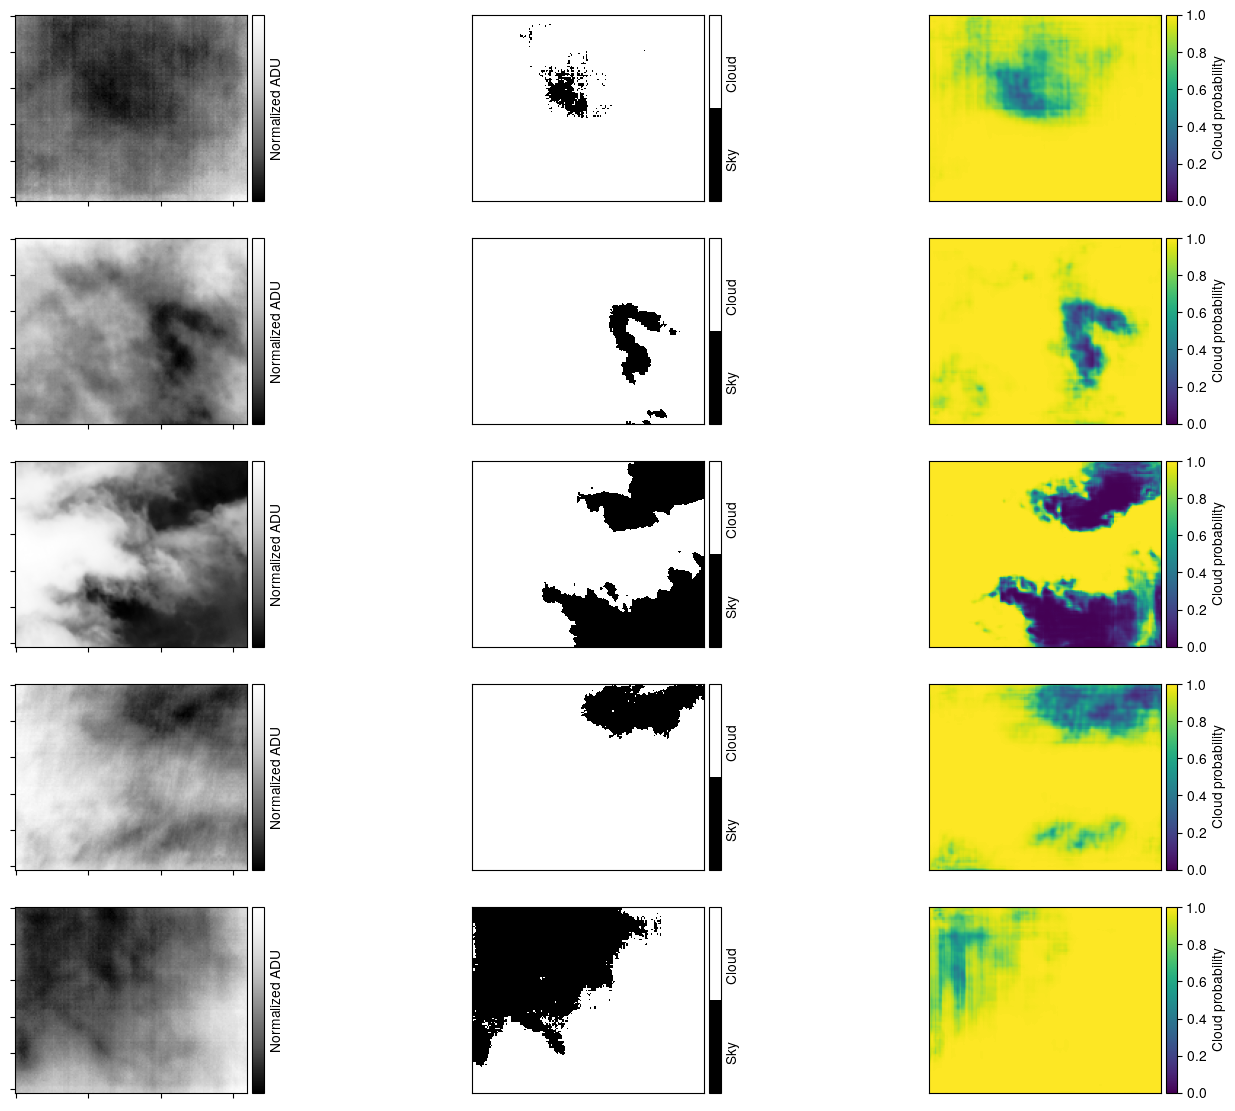

In [5]:
indx = indx + 1
nb = indx*5
print(f"Indx {nb-5} counts {funct(train_fits[nb-5])}")
print(f"Indx {nb-4} counts {funct(train_fits[nb-4])}")
print(f"Indx {nb-3} counts {funct(train_fits[nb-3])}")
print(f"Indx {nb-2} counts {funct(train_fits[nb-2])}")
print(f"Indx {nb-1} counts {funct(train_fits[nb-1])}")
viz.plot_image_preds(train_fits[nb-5:nb],figsize_per_row=(16,14), output_path=None)


/home/sommer/Documents/IR/CLOUD_DETECTION/infrared-cloud-detection/notebooks/../utilities/visualization.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


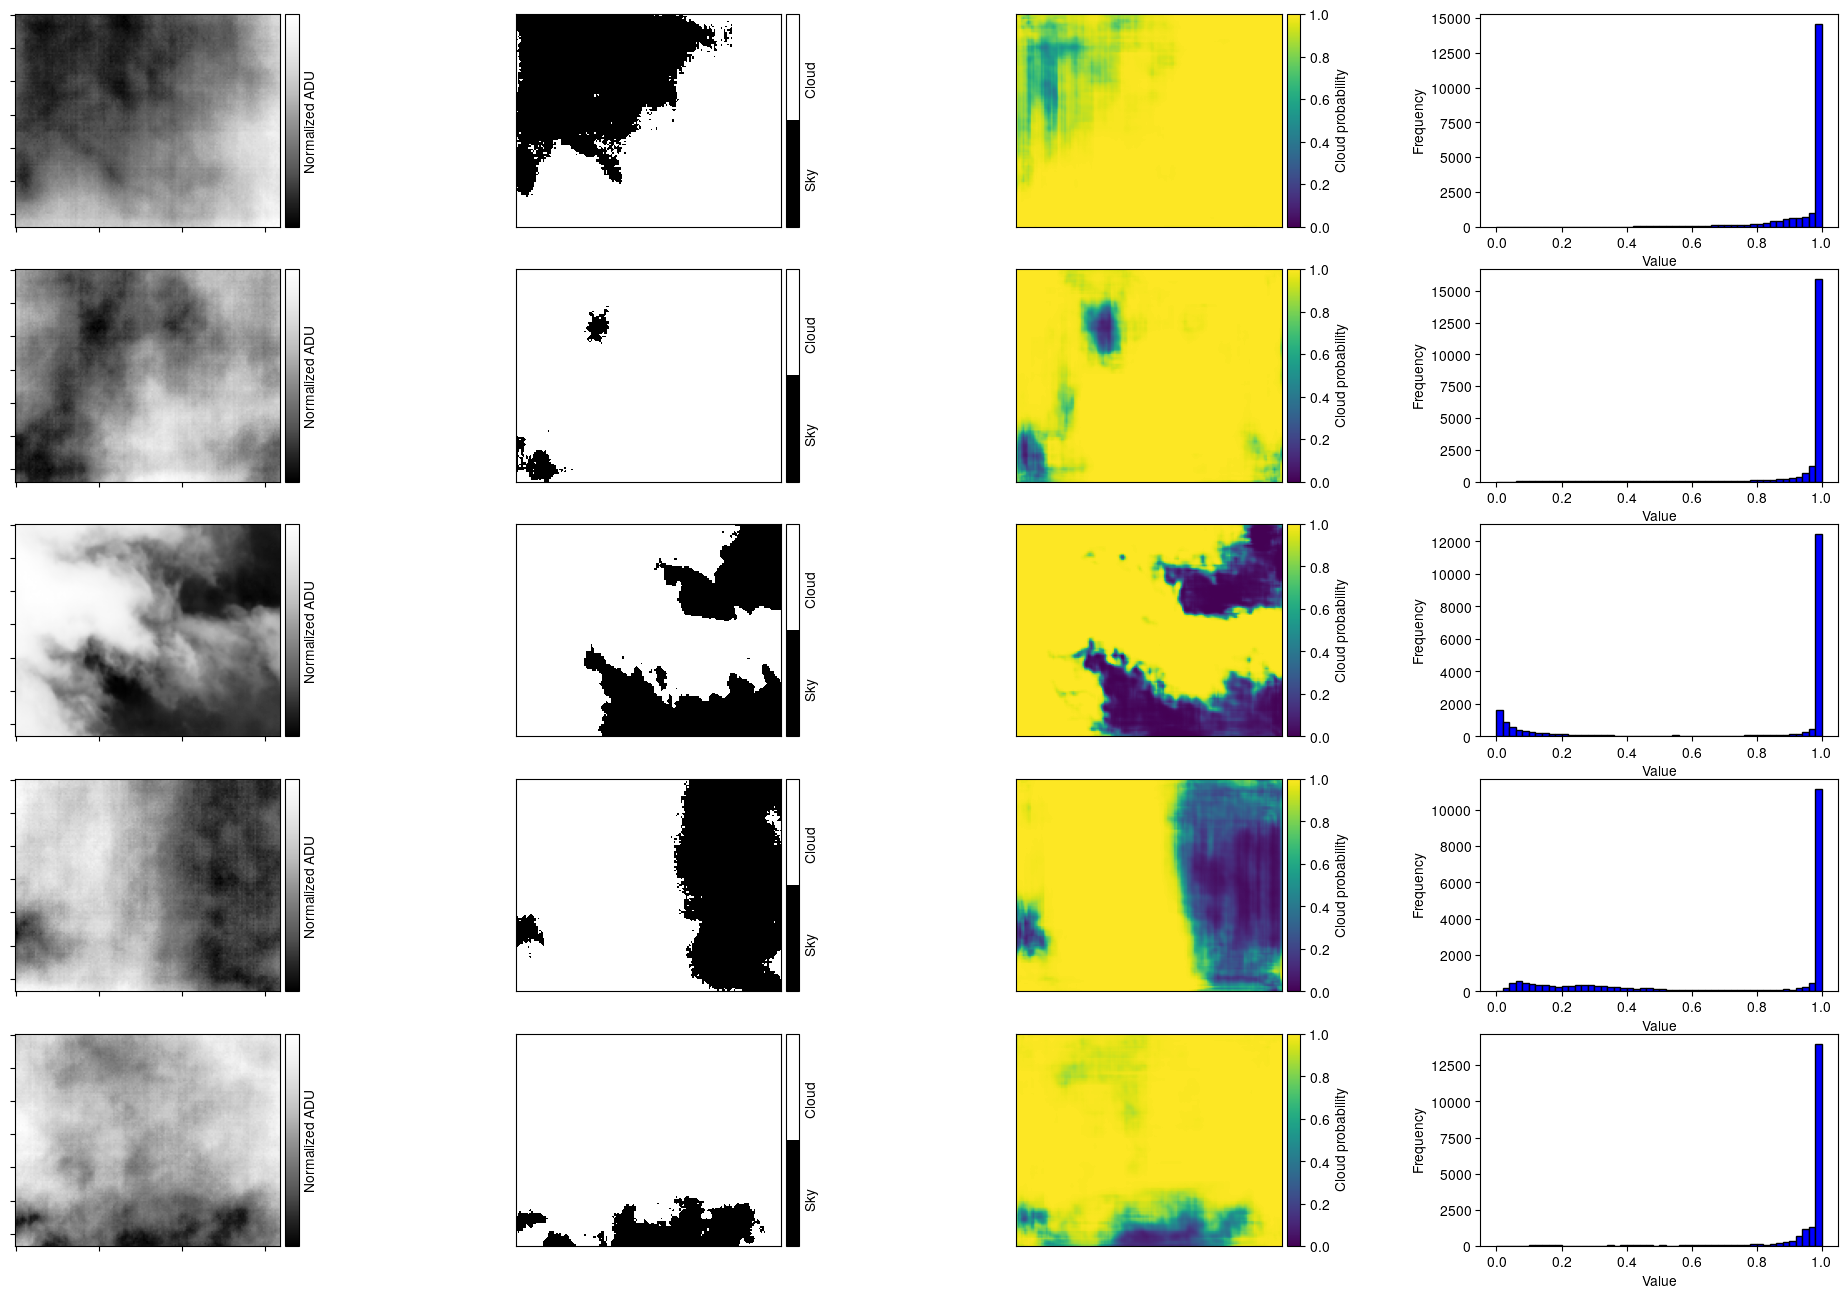

In [6]:
viz.plot_image_preds(data_list=[train_fits[4], train_fits[189], train_fits[171],train_fits[181],train_fits[17]],figsize_per_row=(24,16),predmask_cmap='viridis', output_path=None, include_histogram=True)

In [ ]:
# Example usage:
image_path = 'path_to_your_image.png'  # Replace with your image path
blob_count = process_and_count_blobs(image_path)
sky_quality = quantify_sky_quality(image_path)

print(f'Blob Count: {blob_count}')
print(f'Sky Quality: {sky_quality:.2f}')
